## All imports line below this

In [1]:
# Model: Pytorch and timm
from timm import *
import timm

## Data Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from fastai.data.external import *
from PIL import Image 

# Helper functions
from fastai import *
from fastai.vision.all import *

## Pull Data In

In [2]:
training_df = pd.read_csv("data/training.csv")

# training_df.head(1)

In [3]:
lookup_df = pd.read_csv("data/IdLookupTable.csv")

# lookup_df.head(1)

## Fix up the data a lil

In [4]:
training_df.fillna(method = 'ffill',inplace = True)

In [5]:
training_df.iloc[0:3,0:4]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y
0,66.033564,39.002274,30.227008,36.421678
1,64.332936,34.970077,29.949277,33.448715
2,65.057053,34.909642,30.903789,34.909642


## Show an Image, then show an image with key points


In [6]:


def get_image_tensor(index): 
    img_str = training_df['Image'][index]
    arr = np.fromstring(img_str, dtype=int, sep=' ')
    arr = ['0' if x == '' else x for x in arr]
    arr = tensor(np.array(arr).reshape(96,96))
    return arr

def get_image_arr(index): 
    img_str = training_df['Image'][index]
    arr = np.fromstring(img_str, dtype=int, sep=' ')
    arr = ['0' if x == '' else x for x in arr]
    # arr = tensor(np.array(arr).reshape(96,96))
    return np.array(arr)

def get_key_points(index, num=30):
    coord_arr = []
    for i in range(0,num,2):
        coord = training_df.iloc[index][i],training_df.iloc[index][i+1]
        coord_arr.append(coord)
    return tensor(coord_arr)

def plot_image_with_key_points(index, num_key_points=30, coord_manual_input=[0]):
    image_tensor = get_image_tensor(index)
    coord_arr = get_key_points(index, num_key_points)
    
    
    plt.imshow(image_tensor,cmap='gray')
    
    if coord_manual_input == [0]:
        for coord in coord_arr:
            plt.scatter(coord[0],coord[1],c='pink', marker='s', s=50, alpha=.5)
    else:
        plt.scatter(coord_manual_input[0],coord_manual_input[1],c='r', marker='s', s=60, alpha=.5)
    

In [7]:
type([30,30])

list

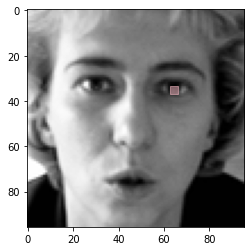

In [8]:
plot_image_with_key_points(1,2)

In [9]:
key_points = get_key_points(1)

type(key_points)

torch.Tensor

In [10]:
arr = get_image_arr(1)
type(arr)
arr.shape



(9216,)

## Train and Test Set Creation

In [11]:
len(training_df)

7049

In [12]:
independent_variable_images = []

for i in range(len(training_df)):
    independent_variable_images.append(get_image_arr(i))
    

In [13]:
image_list = np.array(independent_variable_images,dtype = 'float')

In [14]:
type(image_list)

numpy.ndarray

In [15]:
image_list.shape

(7049, 9216)

In [16]:
independent_vars = image_list.reshape(-1,96,96,1)

In [17]:
independent_vars.shape

(7049, 96, 96, 1)

In [18]:
dependent_vars = training_df.iloc[:,0:30]

In [19]:
dependent_vars.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [20]:
dependent_vars = dependent_vars.to_numpy()

In [21]:
# X_train needs to be of shape 7049, 96, 96, 1
# Y_train needs to be of shape 7049, 30 (or 7049, 2 in the case of only detecting a single eye)
# then yoink X_val and Y_val from X_train and Y_train
independent_vars[0:5000].shape, dependent_vars[0:5000].shape 

((5000, 96, 96, 1), (5000, 30))

In [22]:
X_train = independent_vars[:5000]

In [23]:
X_val = independent_vars[5000:]

In [24]:
X_train.shape, X_val.shape

((5000, 96, 96, 1), (2049, 96, 96, 1))

In [25]:
'''
Returns a training set (X, Y),
and a validation set (X,Y)

usage: 
X_train, Y_train, X_val, Y_val = create_train_test_sets(df)
'''
def create_train_test_sets(training_df):
    
    independent_variable_images = []
    for i in range(len(training_df)):
        independent_variable_images.append(get_image_arr(i))
    image_list = np.array(independent_variable_images,dtype = 'float')
    independent_vars = image_list.reshape(-1,96,96,1) #! Optimize
    

    dependent_vars = training_df.iloc[:,0:30]
    dependent_vars = dependent_vars.to_numpy()
    
    X_train = independent_vars[:5000] # < 5000 --> training set
    X_val = independent_vars[5000:]
    
    Y_train = dependent_vars[:5000]
    Y_val = dependent_vars[5000:] # 5000 onward is validation
    
    return X_train, Y_train, X_val, Y_val
    
    
        
    
    
    

In [ ]:
X, Y, x, y = create_train_test_sets(training_df)

In [ ]:
X.shape, Y.shape, x.shape, y.shape

## Creating a model


In [ ]:
type(model)

In [ ]:
model.eval().conv1 ## First layer of RESNET18